In [1]:
import utils
from pathlib import Path
import pandas as pd

In [2]:
df = utils.load_transactions(Path("../data/jointexpenses/"))
df = utils.clean(df)
print(df.shape)
df = utils.deduplicate_transactions(df)
print(df.shape)
df = utils.classify_transactions(df)

other_transactions = df[df.classification == "Other"]
ground_truth_transactions = df[df.classification != "Other"]

X = ground_truth_transactions.desc
y = ground_truth_transactions.classification

X_other = other_transactions.desc
# y_other = ground_truth_transactions.classification

(1706, 5)
Found 507 duplicated entries 
and 0 duplicates on the same day from the same file.
(765, 5)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# vect_config = {"ngram_range": (1,6)}
# Vectorizer = HashingVectorizer

vect_config = {}
Vectorizer = CountVectorizer

vect = Vectorizer(**vect_config)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_other_dtm = vect.transform(X_other)
# print(vect.vocabulary_)

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 12]
plt.rcParams["figure.dpi"] = 100  # 200 e.g. is really fine, but slower

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
experiments = [
    {"model": MultinomialNB, "config": {}},
    {"model": LogisticRegression, "config": {"class_weight": "balanced"}},
    {"model": LinearSVC, "config": {"class_weight": "balanced"}},
]

In [7]:
predictions = {}
other_predictions = {}

for experiment in experiments:
    Model = experiment["model"]
    config = experiment["config"]
    model = Model(**config)
    model.fit(X_train_dtm, y_train)
    predictions[Model.__name__] = model.predict(X_test_dtm)
    other_predictions[Model.__name__] = model.predict(X_other_dtm)



=====MultinomialNB=====
Accuracy:  0.9453551912568307
(Precision, Recall, F1-score, support): (0.9499758458652513, 0.9453551912568307, 0.9452101781443566, None)


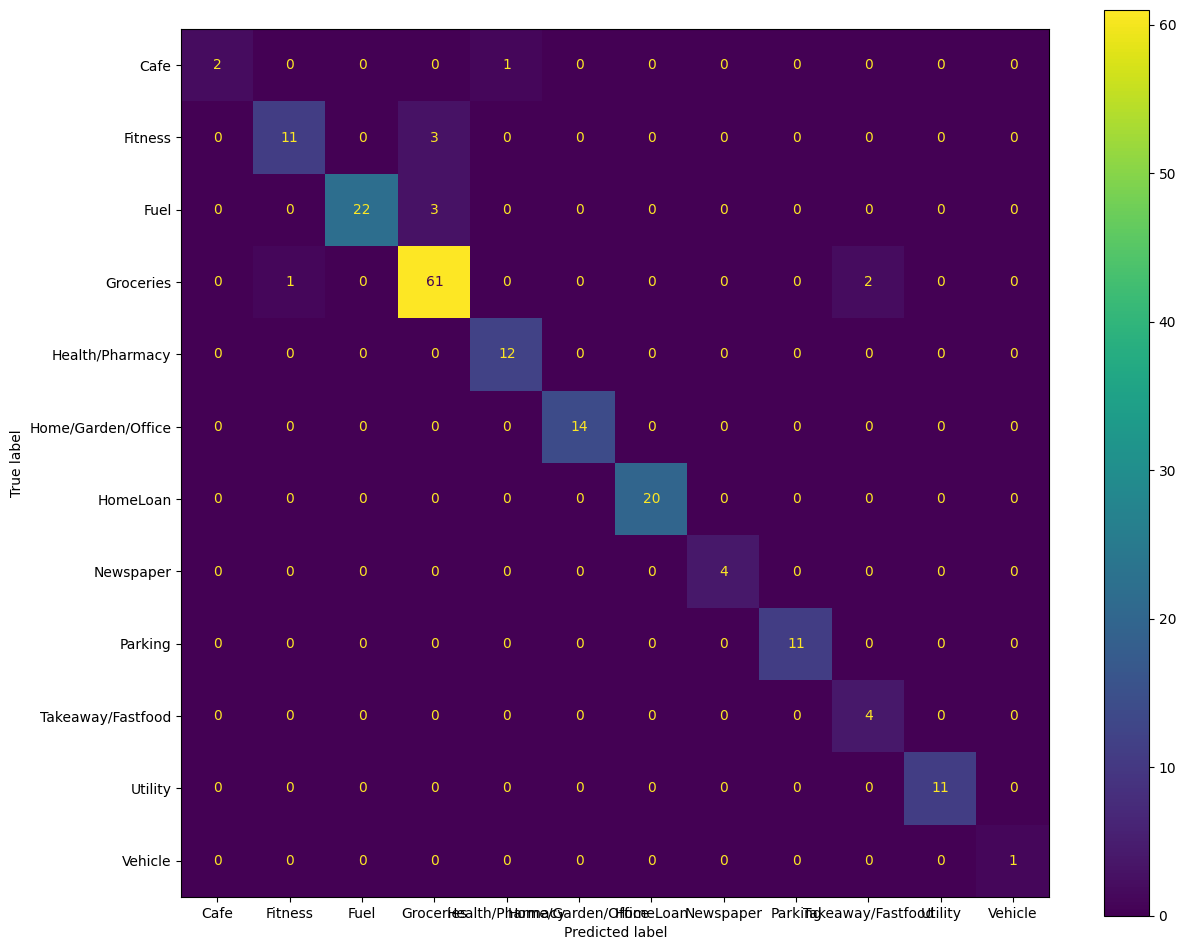

-----Misclassifications-----
                                  desc classification         prediction
71                    URBANBASEFITNESS        Fitness          Groceries
23                    URBANBASEFITNESS        Fitness          Groceries
515             AMPOL TORONTOF TORONTO           Fuel          Groceries
60      METRO PETROLEUM BALLIN BALLINA           Fuel          Groceries
61              CAPE CAFE BYRON BAY NS           Cafe    Health/Pharmacy
106                   URBANBASEFITNESS        Fitness          Groceries
86   THE ESSENTIAL INGRED THE JUNCTION      Groceries            Fitness
277                      COLES WOY WOY      Groceries  Takeaway/Fastfood
538        Enhance Neath Service Neath           Fuel          Groceries
293                      COLES WOY WOY      Groceries  Takeaway/Fastfood


=====LogisticRegression=====
Accuracy:  0.9726775956284153
(Precision, Recall, F1-score, support): (0.9785063752276867, 0.9726775956284153, 0.9736871882938856, None)


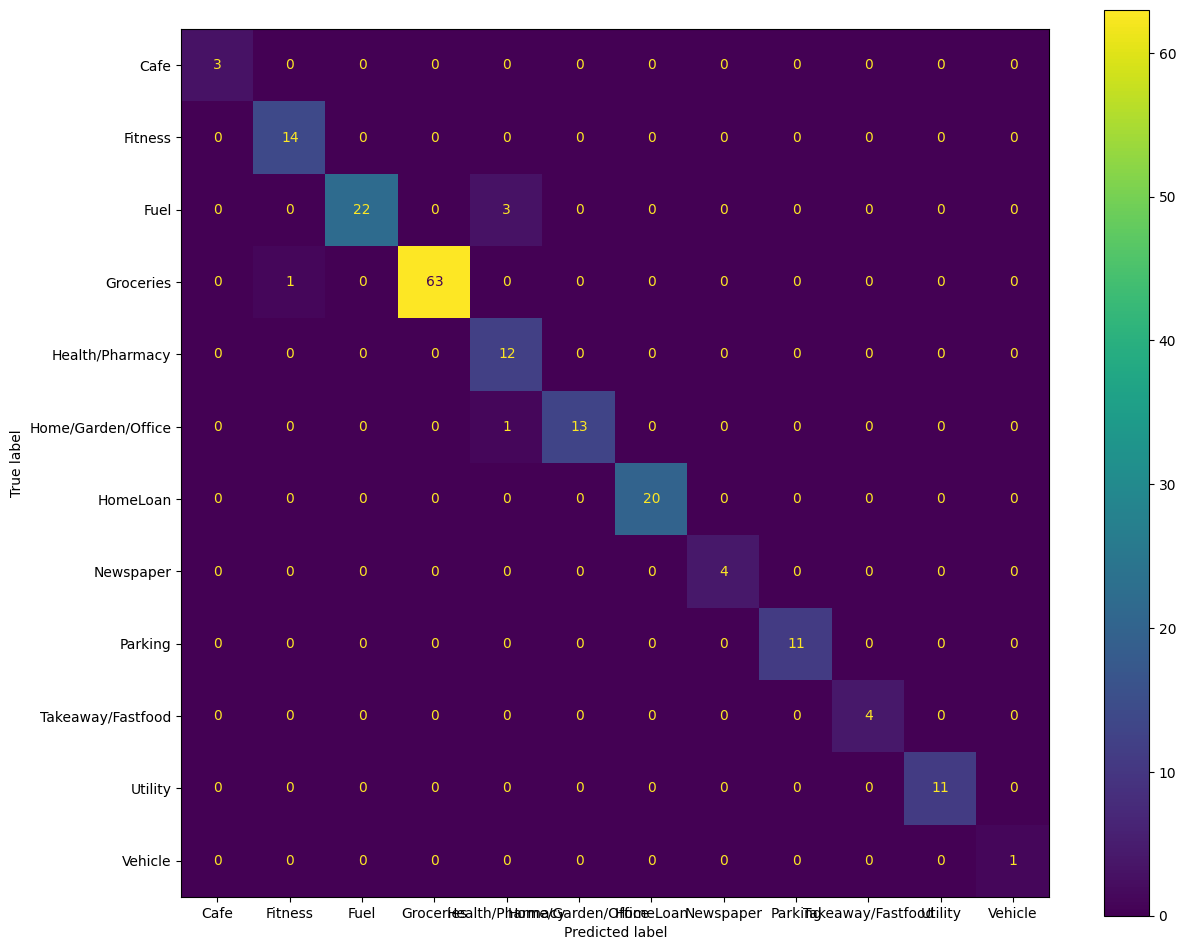

-----Misclassifications-----
                                  desc      classification       prediction
161                 TARGET CHARLESTOWN  Home/Garden/Office  Health/Pharmacy
515             AMPOL TORONTOF TORONTO                Fuel  Health/Pharmacy
60      METRO PETROLEUM BALLIN BALLINA                Fuel  Health/Pharmacy
86   THE ESSENTIAL INGRED THE JUNCTION           Groceries          Fitness
538        Enhance Neath Service Neath                Fuel  Health/Pharmacy


=====LinearSVC=====
Accuracy:  0.9890710382513661
(Precision, Recall, F1-score, support): (0.9904371584699454, 0.9890710382513661, 0.9892076502732241, None)


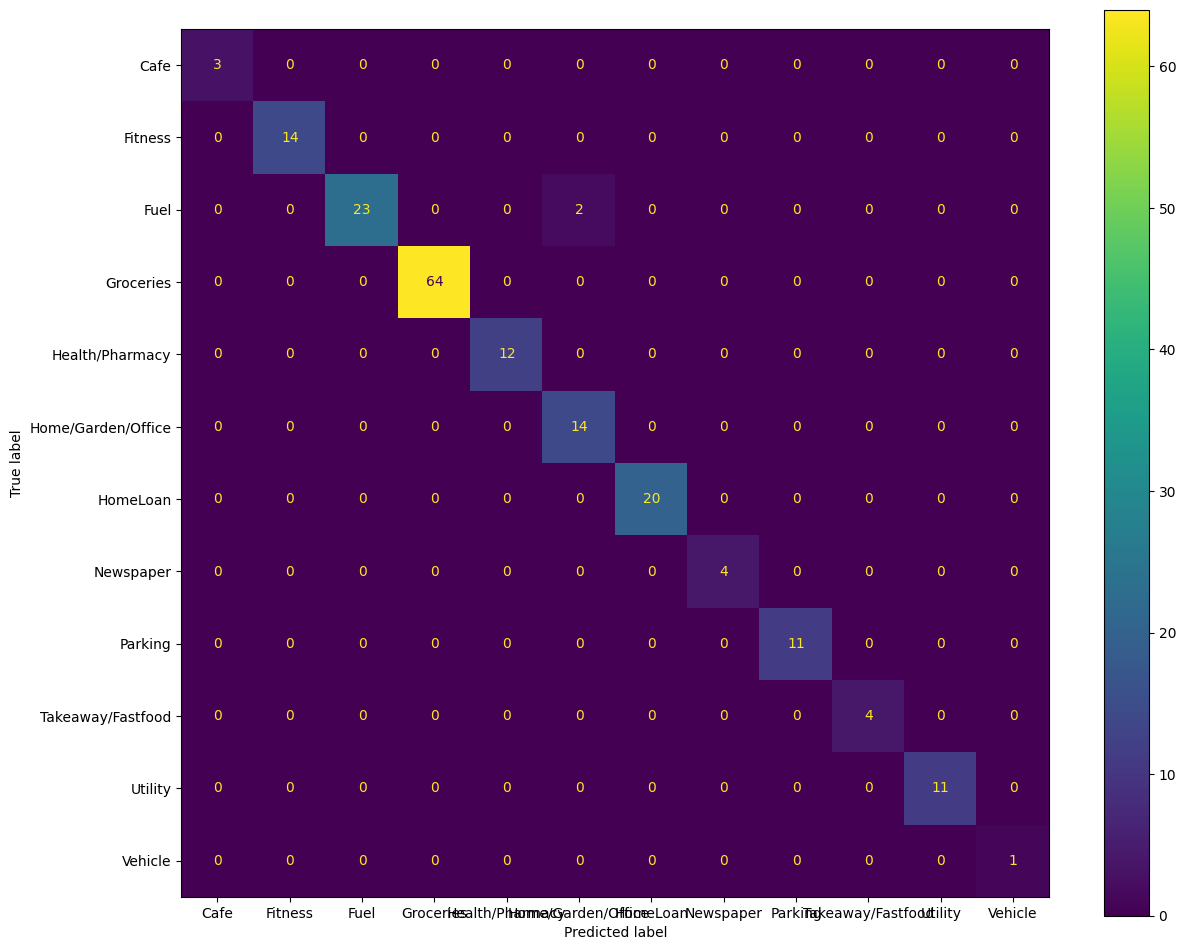

-----Misclassifications-----
                               desc classification          prediction
60   METRO PETROLEUM BALLIN BALLINA           Fuel  Home/Garden/Office
538     Enhance Neath Service Neath           Fuel  Home/Garden/Office


In [8]:
for model_name, y_pred_class in predictions.items():
    print(f"\n\n====={model_name}=====")
    print("Accuracy: ", accuracy_score(y_test, y_pred_class))
    print(
        f"(Precision, Recall, F1-score, support): {precision_recall_fscore_support(y_test, y_pred_class, average='weighted')}"
    )

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class)
    plt.show()

    print("-----Misclassifications-----")
    df = pd.concat([X_test, y_test], axis=1)
    df.loc[:, "prediction"] = y_pred_class
    print(df[df.classification != df.prediction])

In [9]:
# for model_name, y_pred_class in other_predictions.items():
#     print(f"====={model_name}=====")
#     print(len(y_pred_class))
#     print(other_transactions.shape)
#     other_transactions.loc[:, "classification"] = y_pred_class
#     print(other_transactions[["desc", "classification"]])